# MTG Deck builder

In [60]:
from langchain_ollama import ChatOllama, OllamaEmbeddings

llm = ChatOllama(model="llama3.1", num_ctx=8192)
embeddings = OllamaEmbeddings(model="snowflake-arctic-embed2")

In [61]:
from deep_mtg.tools import RulesRetriever, CardsRetriever

In [ ]:
from pathlib import Path

rules_retriever = RulesRetriever(Path('../data/MagicCompRules 20241108.pdf'), embeddings=embeddings)
cards_retriever = CardsRetriever(Path('../data/cards'), llm=llm, embeddings=embeddings)

Loaded 1236 document splits.
Loading ../data/cards/FDN.json...
Creating summaries for 520 cards...


100%|██████████| 520/520 [07:39<00:00,  1.13it/s]


Loaded 520 cards from set ../data/cards/FDN.json.
Dumping vectors to disk ../data/cards/cards.vec


In [62]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
import operator
from typing import Annotated, List, Literal, TypedDict, Optional

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
import json

# class Card(BaseModel):
#     name: str = Field(description="Card name")
#     # type: Annotated[str, ..., "Card type"]
#     cost: Optional[str|int] = Field(default=None, description="Card cost, if applicable")
#     text: Optional[str] = Field(default=None, description="Card text, if applicable")
#     power: Optional[str|int] = Field(default=None, description="Card power, if applicable")
#     toughness: Optional[str|int] = Field(default=None, description="Card toughness, if applicable")

# class DeckState(BaseModel):
#     prompt: str = Field(description="Prompt for the deck")
#     cards: list[Card] = Field(description="List of cards in the deck")
#     n_cards: int = Field(description="Number of cards in the deck")
#     # n_lands: Annotated[int, 0, "Number of lands in the deck"]
#     # n_creatures: Annotated[int, 0, "Number of creatures in the deck"]
#     # n_other: Annotated[int, 0, "Number of other cards in the deck"]

class DeckCard(TypedDict):
    name: Annotated[str, ..., "Card name"]
    types: Annotated[str, ..., "Card type"]
    cost: Annotated[str, ..., "Card cost, including mana colors, if applicable"]
    text: Annotated[str, ..., "Card text, if applicable"]
    power: Annotated[int, ..., "Card power, if applicable"]
    toughness: Annotated[int, ..., "Card toughness, if applicable"]
    description: Annotated[str, ..., "High-level card description"]

class QueryCard(TypedDict):
    colours: Annotated[Optional[str], ..., "Mana colours of the card, if applicable"]
    convertedManaCost: Annotated[int, ..., "Converted mana cost of the card, if applicable"]
    keywords: Annotated[Optional[list[str]], ..., "List of keywords of the card, if applicable"]
    manaCost: Annotated[str, ..., "Mana cost of the card, including colours, if applicable"]
    name: Annotated[str, ..., "Card name"]
    power: Annotated[int, ..., "Card power, if applicable"]
    rarity: Annotated[str, ..., "Card rarity [Common, Uncommon, Rare, Mythic Rare]"]
    subtypes: Annotated[Optional[list[str]], ..., "List of subtypes of the card, if applicable"]
    text: Annotated[str, ..., "Card text, if applicable"]
    toughness: Annotated[int, ..., "Card toughness, if applicable"]
    types: Annotated[str, ..., "Card type"]

class DeckState(TypedDict):
    prompt: Annotated[str, ..., "Deck theme prompt"]
    cards: Annotated[list[DeckCard], [], "List of cards in the deck"]
    n_cards: Annotated[int, 0, "Number of cards in the deck"]
    n_lands: Annotated[int, 0, "Number of lands in the deck"]
    n_creatures: Annotated[int, 0, "Number of creatures in the deck"]
    n_other: Annotated[int, 0, "Number of other cards in the deck"]

In [88]:
from tqdm import tqdm
from collections import defaultdict

def append_card(deck_state: DeckState, card: DeckCard) -> DeckState:
    deck_state['cards'].append(card)
    deck_state['n_cards'] += 1
    if 'land' in card['types']:
        deck_state['n_lands'] += 1
    elif 'creature' in card['types']:
        deck_state['n_creatures'] += 1
    else:
        deck_state['n_other'] += 1

    return deck_state

def build_deck(deck_state: DeckState) -> DeckState:
    deck_state = build_initial_manabase(deck_state, n=18)
    for _ in tqdm(range(60-18)):
        deck_state = add_card(deck_state)
    deck_state = build_final_manabase(deck_state)
    for _ in tqdm(range(60-deck_state['n_cards'])):
        deck_state = add_card(deck_state)
    return deck_state

card_tools_llm = llm.bind_tools([rules_retriever, cards_retriever])
card_advisor_llm = llm
card_advisor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Magic: The Gathering deck builder. "
            "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
            "Given the current state of the deck, provide a high-level description of what card should be added next. "
            "If the deck is empty, suggest a starting card that would be a good fit for the theme. "
            "The desired card doesn't need to actually exist in the game, I will find the closest card that matches your description. "
            "\n"
            "Example descriptions: "
            '\nA cheap, weak, red creature with flying and haste that can be played early in the game'
            '\nA 3-4 mana white sorcery that destroys all creatures which can be used to clear the board in the mid-game'
            '\nA costly blue sorcery that lets you draw multiple cards and can be used to refill your hand in the late game'
            '\nA land that taps for green or black mana and can be used to fix your mana base and to surveil when played'    
            "\n"
            "Only describe one card at a time. "
            "Do not return anything other than the description of the card. "
            "Do not mention the name of the card or the theme of the deck. "
            "Please also describe its role in the deck. "
            "Rather than quantifying attributes of the card, instead use qualitative terms like 'strong' or 'weak' to describe the card. "
            "Remember, the deck should have 60 cards, including lands, and you need to suggest which lands to add. "
            "\n"
            "When choosing the card, consider the following: "
            "\n1. The card should be a good fit for the deck theme. "
            "\n2. The card should be a good fit for the current state of the deck. "
            "\n3. The card should be a good fit for the current metagame. "
            "\n4. What is the card's role in the deck? "
            "\n5. What is the card's impact on the game? "
            "\n6. What is the card's synergy with other cards in the deck? "
            "\n7. What is the card's synergy with the deck's strategy? "
            "\n8. What current weaknesses in the deck does the card address? "
            "\n9. What current strengths in the deck does the card enhance? "
            "\n10. What is the card's mana cost and colour? "
            "\n"
            # "You can use the CardsRetriever tool to find cards that match the description. "
        ),
        (
            "user",
            "The deck theme is {prompt}."
            "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
            "The cards present are: {deck}."
            "Please give a description of what card should be added to the deck."
        ),
    ]
)

class ZeroIndexCardSelection(TypedDict):
    index: Annotated[int, ..., "Zero-indexed index of the card to be added"]
    reason: Annotated[Optional[str], ..., "Reason for selecting the card"]

card_selector_llm = llm.with_structured_output(ZeroIndexCardSelection)
card_selector_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Magic: The Gathering deck builder. "
            "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
            "You are working with a fellow expert deck builder to build a deck. "
            "Your colleague has provided a high-level description of a card that should be added to the deck. "
            "You will be provided with a list of cards that match the description. "
            "You need to select the best card to add to the deck. "
            "The card should be a good fit for the deck theme, the current state of the deck, and the current metagame. "
            "Remeber that a deck cannot have more than 4 copies of a card, unless it is a basic land. "
            
            "\n"
            "When choosing the card, consider the following: "
            "\n1. The card should be a good fit for the deck theme. "
            "\n2. The card should be a good fit for the current state of the deck. "
            "\n3. The card should be a good fit for the current metagame. "
            "\n4. What is the card's role in the deck? "
            "\n5. What is the card's impact on the game? "
            "\n6. What is the card's synergy with other cards in the deck? "
            "\n7. What is the card's synergy with the deck's strategy? "
            "\n8. What current weaknesses in the deck does the card address? "
            "\n9. What current strengths in the deck does the card enhance? "
            "\n10. What is the card's mana cost and colour? "
            "\n"
        ),
        (
            "user",
            "The deck theme is {prompt}."
            "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
            "The cards present are: {deck}."
            "The description of the card that should be added to the deck is: {description}."
            "The list of cards that match the description is: {cards}."
            "Please output the index of the card to be added, using zero-indexing."
        ),
    ]
)

class LandSelector(TypedDict):
    n_forests: Annotated[int, ..., "Number of forests (basic green lands) to add"]
    n_islands: Annotated[int, ..., "Number of islands (basic blue lands) to add"]
    n_mountains: Annotated[int, ..., "Number of mountains (basic red lands) to add"]
    n_plains: Annotated[int, ..., "Number of plains (basic white lands) to add"]
    n_swamps: Annotated[int, ..., "Number of swamps (basic black lands) to add"]
    n_green_white: Annotated[int, ..., "Number of green-white dual lands to add"]
    n_blue_white: Annotated[int, ..., "Number of blue-white dual lands to add"]
    n_black_white: Annotated[int, ..., "Number of black-white dual lands to add"]
    n_red_white: Annotated[int, ..., "Number of red-white dual lands to add"]
    n_green_blue: Annotated[int, ..., "Number of green-blue dual lands to add"]
    n_black_blue: Annotated[int, ..., "Number of black-blue dual lands to add"]
    n_red_blue: Annotated[int, ..., "Number of red-blue dual lands to add"]
    n_green_black: Annotated[int, ..., "Number of green-black dual lands to add"]
    n_red_black: Annotated[int, ..., "Number of red-black dual lands to add"]
    n_other: Annotated[int, ..., "Number of other lands to add, e.g. sac lands, fetch lands, token lands, etc."]

land_selector_llm = llm.with_structured_output(LandSelector)
land_selector_llm = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Magic: The Gathering deck builder. "
            "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
            "You are working with a fellow expert deck builder to build a deck. "
            "Your role is to suggest the best lands to add to the deck. "
            
            "\n"
            "When choosing the card, consider the following: "
            "\n1. The card should be a good fit for the deck theme. "
            "\n2. The card should be a good fit for the current state of the deck. "
            "\n3. The card should be a good fit for the current metagame. "
            "\n4. What is the card's role in the deck? "
            "\n5. What is the card's impact on the game? "
            "\n6. What is the card's synergy with other cards in the deck? "
            "\n7. What is the card's synergy with the deck's strategy? "
            "\n8. What current weaknesses in the deck does the card address? "
            "\n9. What current strengths in the deck does the card enhance? "
            "\n10. What is the card's mana cost and colour? "
            "\n"
        ),
        (
            "user",
            "The deck theme is {prompt}."
            "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
            "The cards present are: {deck}."
            "The description of the card that should be added to the deck is: {description}."
            "The list of cards that match the description is: {cards}."
            "Please output the index of the card to be added, using zero-indexing."
        ),
    ]
)

def build_initial_manabase(deck_state: DeckState, n: int) -> DeckState:

def get_deck_list(deck_state: DeckState) -> tuple[dict[dict[str, int]], str]:
    deck_contents = defaultdict(lambda: defaultdict(int))
    for card in deck_state['cards']:
        entry = f"{card['name']}: {card['description']}"
        types = ','.join(card['types']).lower()
        if 'land' in types:
            deck_contents['lands'][entry] += 1
        elif 'creature' in types:
            deck_contents['creatures'][entry] += 1
        elif 'sorcery' in types:
            deck_contents['sorceries'][entry] += 1
        elif 'instant' in types:
            deck_contents['instants'][entry] += 1
        elif 'enchantment' in types:
            deck_contents['enchantments'][entry] += 1
        elif 'artifact' in types:
            deck_contents['artifacts'][entry] += 1
        else:
            deck_contents['other'][entry] += 1
        
    deck_str = ''
    for card_type, cards in deck_contents.items():
        deck_str += f'\n## {card_type}'
        for card, count in cards.items():
            deck_str += f'\n- {count} x {card}'
    deck_str += '\n'

    return deck_contents, deck_str

def add_card(deck_state: DeckState) -> DeckState:
    prompt = deck_state['prompt']
    if deck_state['n_cards'] == 0:
        prompt = prompt + ' but it is currently empty'

    deck_contents, deck_str = get_deck_list(deck_state)
    print('Current deck:', deck_str)

    desired_card = card_advisor_llm.invoke(card_advisor_prompt.invoke({"prompt": deck_state['prompt'], 
                                 "n_cards": deck_state['n_cards'], 
                                 "n_lands": deck_state.n_lands,
                                   "n_creatures": deck_state.n_creatures,
                                     "n_other": deck_state.n_other, 
                                     "deck": deck_str})
            ).content
        
    print('Recommended card:', desired_card)

    k = 5
    matching_cards = []
    while len(matching_cards) < 5:
        matching_cards = cards_retriever.invoke({'query': desired_card, 'k':k})
        matching_cards_dicts = [json.loads(c) for c in matching_cards]
        # filter out cards that are already in the deck 4 times
        matching_cards = [c for i,c in enumerate(matching_cards) if f'4 x {matching_cards_dicts[i]["name"]}' not in deck_str]
        k += max(1, 5 - len(matching_cards))
    
    matching_cards_dicts = [json.loads(c) for c in matching_cards]  # recreate in case of filtering
    matching_cards_str = '\n'.join([f'index {i}: {c['summary']}' for i,c in enumerate(matching_cards_dicts)])
    print('Matching cards:', matching_cards_str)

    selector_response = None
    card_index = None
    fails = 0
    while selector_response is None:
        if fails > 5:
            print('Failed to correctly select a card after 5 attempts, selecting the zeroth card')
            card_index = 0
            break
        selector_response = card_selector_llm.invoke(card_selector_prompt.invoke({"prompt": deck_state['prompt'],
                                                                    "n_cards": deck_state['n_cards'], 
                                     "n_lands": deck_state.n_lands,
                                       "n_creatures": deck_state.n_creatures,
                                         "n_other": deck_state.n_other, 
                                            "cards": matching_cards_str,
                                        "deck": deck_str,
                                        "description": desired_card})
                )
        if selector_response is not None and selector_response['index'] > len(matching_cards):
            selector_response = None
        fails += 1
    if card_index is None:
        card_index = selector_response['index']
        print(f'Selected card index: {card_index}, reason: {selector_response["reason"]}')
        
    card = matching_cards[card_index]
    print('Matching card:', card)
    
    card = json.loads(card)
    deck_state = append_card(deck_state, DeckCard(name=card['name'],
                 types=card['types'],
                   cost=card['manaCost'], 
                   text=card['text'], 
                   power=card['power'],
                     toughness=card['toughness'],
                     description=card['summary']))
    
    return deck_state



In [81]:
get_card(
    DeckState(prompt="a black creature-focussed deck built around zombies", cards=[], n_cards=0, 
                #    n_lands=0, n_creatures=0, n_other=0
                   )
)

Current deck: 

Recommended card: A strong, one-mana black creature with trample and a low toughness value would be a good starting point for this deck, as it can quickly develop the board and put pressure on the opponent. 

Role in the deck: Early-game aggression and board presence.

Synergy with the deck's strategy: The zombie theme suggests a focus on swarm tactics and exploiting the opponent's life total, so this creature would contribute to that by putting immediate pressure on the opponent.

Impact on the game: It would allow the player to quickly develop their board and put pressure on the opponent early in the game.
Matching cards: index 0: Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an

{'name': 'Soul-Shackled Zombie',
 'types': ['Creature'],
 'cost': '{3}{B}',
 'text': 'When this creature enters, exile up to two target cards from a single graveyard. If at least one creature card was exiled this way, each opponent loses 2 life and you gain 2 life.',
 'power': '4',
 'toughness': '2',
 'description': "Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an opponent's strategy."}

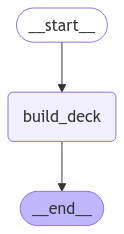

In [85]:
from IPython.display import Image, display

graph = StateGraph(DeckState)
graph.add_node('build_deck', build_deck)
graph.add_edge(START, 'build_deck')
graph.add_edge("build_deck", END)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [86]:
deck = app.invoke({'prompt': "a black creature-focussed deck built around zombies", 'cards': [], 'n_cards': 0, 'n_lands': 0, 'n_creatures': 0, 'n_other': 0})

  0%|          | 0/60 [00:00<?, ?it/s]

Current deck: 

Recommended card: A strong, flying, black creature with decent toughness that can be played on turn 2 or earlier to establish an early presence on the board and set up for future creatures. 

Role in the deck: This card will provide a foundation for the rest of the deck, allowing you to develop a board presence quickly and enabling other cards to take advantage of the early game pressure.

Mana cost and colour: 2-3 black mana
Matching cards: index 0: Skyknight Squire: This is a moderately strong white creature with 2-mana cost. The mana cost is balanced, requiring one colorless and one white mana, making it easily playable early in the game. As a cat and scout, it can take advantage of token-generating strategies. Its ability to gain +1/+1 counters when another creature enters play makes it a great support card for aggro decks. However, its base power and toughness are weak, but it gains flying and Knight abilities once it accumulates enough counters, making it a formid

  2%|▏         | 1/60 [00:06<06:07,  6.23s/it]

Selected card index: 2, reason: The description and role in the deck fit Bloodtithe Collector well as a strong black flying creature with decent toughness that can be played on turn 3 or later to establish an early presence on the board, set up for future creatures.
Matching card: {"summary": "Fleeting Flight is an instant that provides temporary protection and enhancement to a creature. It's weak in terms of mana cost, but strong in its effects, offering a combination of defense and advantage. As a white card, it fits well with the theme of life gain and defensive strategies. Its ability to give flying and prevent damage makes it a good option for protecting a valuable creature from immediate harm.", "colors": ["W"], "convertedManaCost": 1, "keywords": null, "manaCost": "{W}", "name": "Fleeting Flight", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "Put a +1/+1 counter on target creature. It gains flying until end of turn. Prevent all combat damage that 

  3%|▎         | 2/60 [00:07<03:18,  3.42s/it]

Selected card index: 1, reason: This sorcery provides flexibility in casting cost and card draw, allowing for rapid growth of creatures and life gain while being very low-cost.
Matching card: {"summary": "Sanguine Indulgence is a strong sorcery that allows for some flexibility in casting cost and card draw. Its mana cost of three black is moderate, requiring a decent amount of black mana acceleration. This spell has the ability to reduce its own casting cost based on life gain, making it easier to play when ahead in life total. It can also return up to two creature cards from the graveyard to hand, providing some card advantage and flexibility.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Sanguine Indulgence", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "This spell costs {3} less to cast if you've gained 3 or more life this turn.\nReturn up to two target creature cards from your graveyard to your hand.", "t

  5%|▌         | 3/60 [00:09<02:30,  2.65s/it]

Selected card index: 2, reason: Cemetery Recruitment supports Zombie token strategies by bringing back creature cards from the graveyard, potentially drawing additional cards if they are Zombies.
Matching card: {"summary": "Cemetery Recruitment is a strong Blue sorcery that excels at interacting with the graveyard and creating card advantage. Its relatively low mana cost of 1B is weak considering its effect. This card's role is to support Zombie token strategies by bringing back creature cards from the graveyard, potentially drawing additional cards if they are Zombies.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Cemetery Recruitment", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "Return target creature card from your graveyard to your hand. If it's a Zombie card, draw a card.", "toughness": null, "types": ["Sorcery"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that prov

  7%|▋         | 4/60 [00:10<01:53,  2.02s/it]

Selected card index: 0, reason: The deck needs more creatures and this would help accelerate those plans.
Matching card: {"summary": "Dread Summons is a strong, black sorcery that creates an army of 2/2 zombie tokens from milling creatures. It's versatile and can create multiple tokens, making it a great card for token-based strategies. However, its mana cost is somewhat steep due to the variable X cost, which may require significant setup or resource investment. Its mill ability allows it to manipulate cards in the graveyard, adding an additional layer of strategy.  Mana Cost: Expensive and variable, but worth the investment for the right deck.", "colors": ["B"], "convertedManaCost": 2, "keywords": ["Mill"], "manaCost": "{X}{B}{B}", "name": "Dread Summons", "power": null, "rarity": "rare", "subtypes": [], "supertypes": [], "text": "Each player mills X cards. For each creature card put into a graveyard this way, you create a tapped 2/2 black Zombie creature token. (To mill a card, a pl

  8%|▊         | 5/60 [00:12<02:00,  2.19s/it]

Selected card index: 2, reason: The selected card has a moderate power level and can serve as a beatstick or a body for token generation, aligning with the deck’s needs
Matching card: {"summary": "Suspicious Shambler is a moderate-strength, low-toughness black creature. It has an expensive mana cost that's somewhat manageable for its power and toughness. Its key ability allows it to create two smaller zombie tokens when exiled from the graveyard, making it a decent mid-game threat. Overall, it's a decent but not overly impressive card in a black deck.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Suspicious Shambler", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "{4}{B}{B}, Exile this card from your graveyard: Create two 2/2 black Zombie creature tokens. Activate only as a sorcery.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant

 10%|█         | 6/60 [00:17<02:35,  2.87s/it]

Selected card index: 3, reason: The selected card is a good fit for the deck theme, current state of the deck, and metagame. It provides a consistent mid-game threat that can grow in power over time by leveraging existing Zombie token strategies. Its moderate strength, low-toughness, and ability to create smaller zombie tokens when exiled from the graveyard make it an excellent addition to the deck.
Matching card: {"summary": "Suspicious Shambler is a moderate-strength, low-toughness black creature. It has an expensive mana cost that's somewhat manageable for its power and toughness. Its key ability allows it to create two smaller zombie tokens when exiled from the graveyard, making it a decent mid-game threat. Overall, it's a decent but not overly impressive card in a black deck.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Suspicious Shambler", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "{4}{B}{B}

 12%|█▏        | 7/60 [00:20<02:32,  2.89s/it]

Selected card index: 2, reason: The addition of Scavenging Ooze would increase the deck
Matching card: {"summary": "Scavenging Ooze is a strong green creature that excels at cleaning up the graveyard. Its moderate mana cost of one green makes it relatively efficient, but not too weak to be ignored. In play, it has decent power and toughness, making it a viable body on its own. However, its true strength lies in its ability to gain value from the graveyard, allowing you to exile creature cards and gain life or add +1/+1 counters to itself. This makes it a great tool for controlling the opponent's dead creatures and maintaining card advantage over time. Overall, Scavenging Ooze is a solid addition to any green deck looking to leverage graveyard synergy.", "colors": ["G"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{G}", "name": "Scavenging Ooze", "power": "2", "rarity": "rare", "subtypes": ["Ooze"], "supertypes": [], "text": "{G}: Exile target card from a graveyard. If it 

 13%|█▎        | 8/60 [00:23<02:41,  3.11s/it]

Selected card index: 2, reason: The new creature should have a triggered ability that generates value when it dies or is exiled, such as creating Zombie tokens, gaining life, or providing card advantage.
Matching card: {"summary": "Tragic Banshee: This strong black creature is a removal spell in disguise. Its high power and moderate toughness make it a formidable attacker, but its true value lies in its ability to apply massive damage to opponents' creatures when they die, making it a key part of a mid-game strategy. The 5 mana cost is moderately expensive for a black creature, indicating that this card rewards careful planning and can be a game-changer with the right setup.", "colors": ["B"], "convertedManaCost": 5, "keywords": ["Morbid"], "manaCost": "{4}{B}", "name": "Tragic Banshee", "power": "5", "rarity": "uncommon", "subtypes": ["Spirit"], "supertypes": [], "text": "Morbid \u2014 When this creature enters, target creature an opponent controls gets -1/-1 until end of turn. If a c

 15%|█▌        | 9/60 [00:26<02:38,  3.10s/it]

Selected card index: 3, reason: The selected card, Suspicious Shambler, is a moderate-strength black creature with zombie token generation and graveyard interaction, fitting the deck theme and strategy.
Matching card: {"summary": "Suspicious Shambler is a moderate-strength, low-toughness black creature. It has an expensive mana cost that's somewhat manageable for its power and toughness. Its key ability allows it to create two smaller zombie tokens when exiled from the graveyard, making it a decent mid-game threat. Overall, it's a decent but not overly impressive card in a black deck.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Suspicious Shambler", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "{4}{B}{B}, Exile this card from your graveyard: Create two 2/2 black Zombie creature tokens. Activate only as a sorcery.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## instants
- 1 x Fleeting Fli

 17%|█▋        | 10/60 [00:28<02:10,  2.61s/it]

Selected card index: 1, reason: The deck theme is a black creature-focussed deck built around zombies and the current metagame suggests that adding more black mana acceleration would be beneficial.
Matching card: {"summary": "Swamp is a weak, color-fixing basic land that provides black mana. It's simple and straightforward, allowing you to add one black mana to your pool for a low cost.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swamp", "power": null, "rarity": "common", "subtypes": ["Swamp"], "supertypes": ["Basic"], "text": "({T}: Add {B}.)", "toughness": null, "types": ["Land"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that provides temporary protection and enhancement to a creature. It's weak in terms of mana cost, but strong in its effects, offering a combination of defense and advantage. As a white card, it fits well with the theme of life gain and defensive strategies. Its ability to give flying and

 18%|█▊        | 11/60 [00:31<02:12,  2.70s/it]

Selected card index: 0, reason: The card should provide a more efficient way to swarm the board with zombies, offer a threat that can take advantage of lifelink synergies with other cards in the deck, and help address the current weakness of having few low-cost creature options.
Matching card: {"summary": "Crypt Feaster is a strong Zombie creature that excels at dealing with opponents with low life totals. Its ability to become unblockable against single targets makes it difficult for them to defend against, and its +2/+0 boost from Threshold can further solidify its presence on the battlefield.  The mana cost of {3}{B} is moderate in terms of black mana investment, but the payoff is substantial with this creature's menace ability. Overall, Crypt Feaster is a strong and aggressive card that excels at taking advantage of opponents' weak spots.", "colors": ["B"], "convertedManaCost": 4, "keywords": ["Menace", "Threshold"], "manaCost": "{3}{B}", "name": "Crypt Feaster", "power": "3", "rar

 20%|██        | 12/60 [00:33<02:08,  2.68s/it]

Selected card index: 2, reason: Add 2 copies of the 3 mana cost, black sorcery that creates a strong zombie token with an ability that gives it a bonus when attacking
Matching card: {"summary": "Dread Summons is a strong, black sorcery that creates an army of 2/2 zombie tokens from milling creatures. It's versatile and can create multiple tokens, making it a great card for token-based strategies. However, its mana cost is somewhat steep due to the variable X cost, which may require significant setup or resource investment. Its mill ability allows it to manipulate cards in the graveyard, adding an additional layer of strategy.  Mana Cost: Expensive and variable, but worth the investment for the right deck.", "colors": ["B"], "convertedManaCost": 2, "keywords": ["Mill"], "manaCost": "{X}{B}{B}", "name": "Dread Summons", "power": null, "rarity": "rare", "subtypes": [], "supertypes": [], "text": "Each player mills X cards. For each creature card put into a graveyard this way, you create a 

 22%|██▏       | 13/60 [00:36<02:08,  2.73s/it]

Selected card index: 0, reason: Land acceleration and color fixing
Matching card: {"summary": "Swamp is a weak, color-fixing basic land that provides black mana. It's simple and straightforward, allowing you to add one black mana to your pool for a low cost.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swamp", "power": null, "rarity": "common", "subtypes": ["Swamp"], "supertypes": ["Basic"], "text": "({T}: Add {B}.)", "toughness": null, "types": ["Land"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that provides temporary protection and enhancement to a creature. It's weak in terms of mana cost, but strong in its effects, offering a combination of defense and advantage. As a white card, it fits well with the theme of life gain and defensive strategies. Its ability to give flying and prevent damage makes it a good option for protecting a valuable creature from immediate harm.
## sorceries
- 1 x Sanguine Indulgen

 23%|██▎       | 14/60 [00:38<01:51,  2.42s/it]

Selected card index: 1, reason: The selected card, Tragic Banshee, is a strong black creature that fits well with the deck theme and strategy.
Matching card: {"summary": "Tragic Banshee: This strong black creature is a removal spell in disguise. Its high power and moderate toughness make it a formidable attacker, but its true value lies in its ability to apply massive damage to opponents' creatures when they die, making it a key part of a mid-game strategy. The 5 mana cost is moderately expensive for a black creature, indicating that this card rewards careful planning and can be a game-changer with the right setup.", "colors": ["B"], "convertedManaCost": 5, "keywords": ["Morbid"], "manaCost": "{4}{B}", "name": "Tragic Banshee", "power": "5", "rarity": "uncommon", "subtypes": ["Spirit"], "supertypes": [], "text": "Morbid \u2014 When this creature enters, target creature an opponent controls gets -1/-1 until end of turn. If a creature died this turn, that creature gets -13/-13 instead.",

 25%|██▌       | 15/60 [00:40<01:45,  2.34s/it]

Selected card index: 0, reason: The selected card has moderate toughness and power, a unique ability that synergizes well with existing creatures in the deck, and can become more formidable when its controller has multiple Zombie tokens on the battlefield
Matching card: {"summary": "Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an opponent's strategy.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Soul-Shackled Zombie", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature enters, exile up to two target cards from a single graveyard. If at least one creature card was exiled this way, each opponent loses

 27%|██▋       | 16/60 [00:42<01:40,  2.28s/it]

Selected card index: 2, reason: The deck needs a cheap, moderate-strength black creature with decent toughness that can be played early in the game to set up future board presence and support the Zombie token strategies.
Matching card: {"summary": "Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an opponent's strategy.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Soul-Shackled Zombie", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature enters, exile up to two target cards from a single graveyard. If at least one creature card was exiled this way, each opponent loses 2 life and you gain 2 life.", "tou

 28%|██▊       | 17/60 [00:46<02:00,  2.80s/it]

Selected card index: 3, reason: The deck needs a moderate-strength, 3-4 mana black creature with a zombie-like ability that synergizes well with the existing creatures in the deck. Death Baron fits this description as it provides significant tribal support for black zombies and has moderate power and toughness.
Matching card: {"summary": "Death Baron: A strong, flying zombie creature that offers significant tribal support for black zombies, providing them with +1/+1 and deathtouch. Its moderate power and toughness make it a solid threat in combat. The mana cost of 3BB is somewhat expensive, but its impact on the board makes it worth the investment.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Death Baron", "power": "2", "rarity": "rare", "subtypes": ["Zombie", "Wizard"], "supertypes": [], "text": "Skeletons you control and other Zombies you control get +1/+1 and have deathtouch. (Any amount of damage they deal to a creature is enough to

 30%|███       | 18/60 [00:50<02:06,  3.02s/it]

Selected card index: 1, reason: Based on the description provided, Death Baron is a strong creature with a moderate to high power and toughness that can interact well with the existing Zombie creatures in the deck. Its ability to provide +1/+1 and deathtouch makes it an excellent addition to the deck, addressing the strength of dealing significant damage to opponents' creatures when they die.
Matching card: {"summary": "Death Baron: A strong, flying zombie creature that offers significant tribal support for black zombies, providing them with +1/+1 and deathtouch. Its moderate power and toughness make it a solid threat in combat. The mana cost of 3BB is somewhat expensive, but its impact on the board makes it worth the investment.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Death Baron", "power": "2", "rarity": "rare", "subtypes": ["Zombie", "Wizard"], "supertypes": [], "text": "Skeletons you control and other Zombies you control get +1

 32%|███▏      | 19/60 [00:53<02:02,  2.98s/it]

Selected card index: 3, reason: The description of the card that should be added to the deck is: A cheap, black creature with moderate power and toughness, possibly with some form of regeneration or lifelink to complement the deck
Matching card: {"summary": "Sanguine Syphoner is a black creature with moderate strength. Its mana cost of one colorless and one black mana is relatively weak to cast early in the game but manageable later on. This creature excels at attacking, making opponents lose life while you gain it. However, its toughness of three makes it somewhat durable against damage. Overall, Sanguine Syphoner is a decent attacker with some life-gaining potential.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Sanguine Syphoner", "power": "1", "rarity": "common", "subtypes": ["Vampire", "Warlock"], "supertypes": [], "text": "Whenever this creature attacks, each opponent loses 1 life and you gain 1 life.", "toughness": "3", "types": ["Cr

 33%|███▎      | 20/60 [00:55<01:57,  2.93s/it]

Selected card index: 2, reason: Scavenging Ooze's ability to gain value from the graveyard aligns well with the deck's theme of leveraging graveyard synergy, and its moderate mana cost makes it an efficient addition. Its impact on the game can help create a steady stream of card advantage and resource generation, addressing the current weakness of low mid-game threats.
Matching card: {"summary": "Scavenging Ooze is a strong green creature that excels at cleaning up the graveyard. Its moderate mana cost of one green makes it relatively efficient, but not too weak to be ignored. In play, it has decent power and toughness, making it a viable body on its own. However, its true strength lies in its ability to gain value from the graveyard, allowing you to exile creature cards and gain life or add +1/+1 counters to itself. This makes it a great tool for controlling the opponent's dead creatures and maintaining card advantage over time. Overall, Scavenging Ooze is a solid addition to any gree

 35%|███▌      | 21/60 [01:02<02:36,  4.00s/it]

Selected card index: 3, reason: The selected card, Soul-Shackled Zombie, fits well with the deck theme and strategy, providing moderate toughness and power while offering a strong ability to exile graveyard cards for potential card advantage and disruption of opponents
Matching card: {"summary": "Zombify is a strong sorcery that allows you to return a creature from your graveyard back into play. It's a black card with a moderate mana cost of 3BB, making it relatively easy to cast once you have the right colors established. This card excels at recycling creatures and giving them another chance to contribute to your game plan. Its weakness lies in being a single-use effect that doesn't provide immediate value or protection from future threats.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Zombify", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "Return target creature card from your graveyard to the battlefield

 37%|███▋      | 22/60 [01:04<02:13,  3.52s/it]

Selected card index: 2, reason: The deck needs a removal spell in disguise that can apply massive damage to opponents' creatures when they die, and Tragic Banshee fits well with the mid-game strategy. Its moderate expense is worth the investment for careful planning and setup.
Matching card: {"summary": "Tragic Banshee: This strong black creature is a removal spell in disguise. Its high power and moderate toughness make it a formidable attacker, but its true value lies in its ability to apply massive damage to opponents' creatures when they die, making it a key part of a mid-game strategy. The 5 mana cost is moderately expensive for a black creature, indicating that this card rewards careful planning and can be a game-changer with the right setup.", "colors": ["B"], "convertedManaCost": 5, "keywords": ["Morbid"], "manaCost": "{4}{B}", "name": "Tragic Banshee", "power": "5", "rarity": "uncommon", "subtypes": ["Spirit"], "supertypes": [], "text": "Morbid \u2014 When this creature enters,

 38%|███▊      | 23/60 [01:11<02:41,  4.36s/it]

Selected card index: 1, reason: The card needs to be a strong, cheap, black creature with moderate power and toughness that can be played early in the game, potentially serving as a threat or a blocker. Vampire Gourmand matches this description well.
Matching card: {"summary": "Vampire Gourmand is a strong black creature with moderate power and toughness. Its ability to attack and potentially draw a card makes it a formidable presence on the battlefield, but its vulnerability to being sacrificed for an additional effect can be a weakness. The low mana cost of {1}{B} suggests that this creature can be played early in the game, giving it a potential advantage in aggressive decks. Overall, Vampire Gourmand is a flexible and potentially impactful creature with a unique ability that rewards sacrificing another creature to fuel its power.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Vampire Gourmand", "power": "2", "rarity": "uncommon", "subtype

 40%|████      | 24/60 [01:15<02:41,  4.49s/it]

Selected card index: 3, reason: The selected card, Scavenging Ooze, fits well with the deck theme, current state of the deck, and metagame. Its moderate mana cost and ability to gain value from the graveyard make it a good fit for the deck. It synergizes with existing cards in the deck such as Sanguine Indulgence and Cemetery Recruitment, providing additional threat density and support for the Zombie token strategy while offering opportunities for card advantage.
Matching card: {"summary": "Scavenging Ooze is a strong green creature that excels at cleaning up the graveyard. Its moderate mana cost of one green makes it relatively efficient, but not too weak to be ignored. In play, it has decent power and toughness, making it a viable body on its own. However, its true strength lies in its ability to gain value from the graveyard, allowing you to exile creature cards and gain life or add +1/+1 counters to itself. This makes it a great tool for controlling the opponent's dead creatures an

 42%|████▏     | 25/60 [01:18<02:18,  3.96s/it]

Selected card index: 2, reason: The description of the card that should be added to the deck is: A moderate-strength, mid-game threat with a strong ability that synergizes well with the existing creatures in the deck. A creature that can be played around turn 4-5 with a decent power and toughness, and has an ability that benefits from having other zombies on the board. Its mana cost should be somewhat expensive, but not too steep to make it unplayable.
Matching card: {"summary": "Crypt Feaster is a strong Zombie creature that excels at dealing with opponents with low life totals. Its ability to become unblockable against single targets makes it difficult for them to defend against, and its +2/+0 boost from Threshold can further solidify its presence on the battlefield.  The mana cost of {3}{B} is moderate in terms of black mana investment, but the payoff is substantial with this creature's menace ability. Overall, Crypt Feaster is a strong and aggressive card that excels at taking adva

 43%|████▎     | 26/60 [01:22<02:09,  3.81s/it]

Selected card index: 2, reason: This card will help to fuel the graveyard strategies by providing card advantage whenever creatures die. It fits well with the overall theme of leveraging the graveyard for its value and can help to mitigate some of the weaknesses present in the current deck, such as the high mana costs associated with cards like Dread Summons.
Matching card: {"summary": "Sanguine Indulgence is a strong sorcery that allows for some flexibility in casting cost and card draw. Its mana cost of three black is moderate, requiring a decent amount of black mana acceleration. This spell has the ability to reduce its own casting cost based on life gain, making it easier to play when ahead in life total. It can also return up to two creature cards from the graveyard to hand, providing some card advantage and flexibility.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Sanguine Indulgence", "power": null, "rarity": "common", "subtypes": [

 45%|████▌     | 27/60 [01:24<01:53,  3.45s/it]

Selected card index: 0, reason: The selected card is a strong mid-game threat with some resilience against removal spells and synergy with existing creatures in the deck.
Matching card: {"summary": "Tragic Banshee: This strong black creature is a removal spell in disguise. Its high power and moderate toughness make it a formidable attacker, but its true value lies in its ability to apply massive damage to opponents' creatures when they die, making it a key part of a mid-game strategy. The 5 mana cost is moderately expensive for a black creature, indicating that this card rewards careful planning and can be a game-changer with the right setup.", "colors": ["B"], "convertedManaCost": 5, "keywords": ["Morbid"], "manaCost": "{4}{B}", "name": "Tragic Banshee", "power": "5", "rarity": "uncommon", "subtypes": ["Spirit"], "supertypes": [], "text": "Morbid \u2014 When this creature enters, target creature an opponent controls gets -1/-1 until end of turn. If a creature died this turn, that crea

 47%|████▋     | 28/60 [01:26<01:39,  3.10s/it]

Selected card index: 4, reason: The description matches Maalfeld Twins, which provides a mid-game threat and generates card advantage through token creation.
Matching card: {"summary": "Maalfeld Twins is a strong, undead creature that costs moderate to high mana ({5}{B}) in the dark, controlling color. It has decent power and toughness, making it a viable attacker on its own. Its true strength lies in its ability to create two 2/2 Zombie tokens when it dies, allowing for a swarm of undead creatures to overwhelm opponents. This makes Maalfeld Twins a valuable asset in black-based strategies focused on creature advantage and token generation.", "colors": ["B"], "convertedManaCost": 6, "keywords": null, "manaCost": "{5}{B}", "name": "Maalfeld Twins", "power": "4", "rarity": "uncommon", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature dies, create two 2/2 black Zombie creature tokens.", "toughness": "4", "types": ["Creature"]}
Current deck: 
## instants
- 1 x Fleeting 

 48%|████▊     | 29/60 [01:29<01:33,  3.02s/it]

Selected card index: 0, reason: The deck theme is a black creature-focussed deck built around zombies. The current deck consists of 28 cards and the selected card has a moderate-strength, strong, black creature with an expensive but manageable mana cost, decent power and toughness, making it a viable attacker in mid-game situations.
Matching card: {"summary": "Crypt Feaster is a strong Zombie creature that excels at dealing with opponents with low life totals. Its ability to become unblockable against single targets makes it difficult for them to defend against, and its +2/+0 boost from Threshold can further solidify its presence on the battlefield.  The mana cost of {3}{B} is moderate in terms of black mana investment, but the payoff is substantial with this creature's menace ability. Overall, Crypt Feaster is a strong and aggressive card that excels at taking advantage of opponents' weak spots.", "colors": ["B"], "convertedManaCost": 4, "keywords": ["Menace", "Threshold"], "manaCost"

 50%|█████     | 30/60 [01:32<01:23,  2.79s/it]

Selected card index: 0, reason: The deck needs a moderate-strength mid-game threat that can benefit from graveyard synergies and deal with opponents' creatures.
Matching card: {"summary": "Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an opponent's strategy.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Soul-Shackled Zombie", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature enters, exile up to two target cards from a single graveyard. If at least one creature card was exiled this way, each opponent loses 2 life and you gain 2 life.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## insta

 52%|█████▏    | 31/60 [01:34<01:19,  2.73s/it]

Selected card index: 3, reason: The deck is looking for a cheap, weak black creature with moderate toughness and power that can be played early in the game as a potential sacrifice or chump blocker.
Matching card: {"summary": "Hungry Ghoul is a common black creature with a moderate mana cost of one blue mana. It has average power and toughness, making it a decent body for the board. Its ability to gain +1/+1 counters by sacrificing another creature makes it stronger in mid-game when you can take advantage of this synergistic effect, but weak at early stages without other creatures to sacrifice.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Hungry Ghoul", "power": "2", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "{1}, Sacrifice another creature: Put a +1/+1 counter on this creature.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that provide

 53%|█████▎    | 32/60 [01:36<01:10,  2.53s/it]

Selected card index: 1, reason: The card should be a good fit for the deck theme, current state of the deck, and current metagame. It should have strong effects that complement existing creatures, allow for aggressive playstyle, provide deathtouch and flying to disrupt opponents' plans, and reward early game development.
Matching card: {"summary": "Bloodthirsty Conqueror is a strong black creature with flying and deathtouch, making it well-suited for dealing direct damage to opponents. Its moderate mana cost of three black is somewhat high, but not overly expensive given its power and toughness. The card excels at converting life loss into life gain for the player, making it a great asset in situations where opponents are taking significant damage. However, its low toughness compared to its power makes it vulnerable to large creatures with trample.", "colors": ["B"], "convertedManaCost": 5, "keywords": ["Deathtouch", "Flying"], "manaCost": "{3}{B}{B}", "name": "Bloodthirsty Conqueror",

 55%|█████▌    | 33/60 [01:40<01:20,  2.99s/it]

Selected card index: 0, reason: The selected card is a strong and aggressive Zombie creature that fits the deck's theme and strategy, providing potential for life gain and advantage through its ability.
Matching card: {"summary": "Crypt Feaster is a strong Zombie creature that excels at dealing with opponents with low life totals. Its ability to become unblockable against single targets makes it difficult for them to defend against, and its +2/+0 boost from Threshold can further solidify its presence on the battlefield.  The mana cost of {3}{B} is moderate in terms of black mana investment, but the payoff is substantial with this creature's menace ability. Overall, Crypt Feaster is a strong and aggressive card that excels at taking advantage of opponents' weak spots.", "colors": ["B"], "convertedManaCost": 4, "keywords": ["Menace", "Threshold"], "manaCost": "{3}{B}", "name": "Crypt Feaster", "power": "3", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "Menace (Th

 57%|█████▋    | 34/60 [01:42<01:11,  2.75s/it]

Selected card index: 2, reason: The description provided matches Empyrean Eagle's role and impact on the game. It is a strong flying creature that provides potential synergies with other creatures in the deck, making it an ideal candidate for the described position.
Matching card: {"summary": "Empyrean Eagle is a strong flying creature that supports your team. It's a 2/3 creature itself, but its ability to give other flying creatures +1/+1 makes it particularly valuable in a multi-flyer strategy. The mana cost of {1}{W}{U} is moderate for a flying creature, with White and Blue providing a balance between removal and card draw.", "colors": ["U", "W"], "convertedManaCost": 3, "keywords": ["Flying"], "manaCost": "{1}{W}{U}", "name": "Empyrean Eagle", "power": "2", "rarity": "uncommon", "subtypes": ["Bird", "Spirit"], "supertypes": [], "text": "Flying\nOther creatures you control with flying get +1/+1.", "toughness": "3", "types": ["Creature"]}
Current deck: 
## instants
- 1 x Fleeting Fli

 58%|█████▊    | 35/60 [01:48<01:28,  3.52s/it]

Selected card index: 3, reason: The deck needs a moderately-priced, black creature with abilities that interact with the graveyard and provide card advantage
Matching card: {"summary": "Suspicious Shambler is a moderate-strength, low-toughness black creature. It has an expensive mana cost that's somewhat manageable for its power and toughness. Its key ability allows it to create two smaller zombie tokens when exiled from the graveyard, making it a decent mid-game threat. Overall, it's a decent but not overly impressive card in a black deck.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Suspicious Shambler", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "{4}{B}{B}, Exile this card from your graveyard: Create two 2/2 black Zombie creature tokens. Activate only as a sorcery.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that provi

 60%|██████    | 36/60 [01:50<01:18,  3.27s/it]

Selected card index: 2, reason: The deck needs a strong mid-game creature that can attack and potentially gain life or create zombie tokens when it dies, fitting well with the theme of zombies and graveyard synergy. Death Baron has moderate power and toughness, making it a solid threat in combat, and its impact on the board makes it worth the investment.
Matching card: {"summary": "Death Baron: A strong, flying zombie creature that offers significant tribal support for black zombies, providing them with +1/+1 and deathtouch. Its moderate power and toughness make it a solid threat in combat. The mana cost of 3BB is somewhat expensive, but its impact on the board makes it worth the investment.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Death Baron", "power": "2", "rarity": "rare", "subtypes": ["Zombie", "Wizard"], "supertypes": [], "text": "Skeletons you control and other Zombies you control get +1/+1 and have deathtouch. (Any amount of

 62%|██████▏   | 37/60 [01:57<01:35,  4.14s/it]

Selected card index: 3, reason: The card's ability to generate a token based on the card exiled from the graveyard makes it a potential engine of token generation, which aligns with the deck's strategy of creating multiple threats on the board. Its moderate mana cost and powerful effect make it a good fit for this deck.
Matching card: {"summary": "Abyssal Harvester is a strong black creature with a moderate mana cost that's slightly steep for its power and toughness. It has a unique ability at instant speed that allows it to generate a token based on the card exiled from the graveyard, making it a potential engine of token generation. However, its ability also weakens itself by exiling other Nightmare tokens under its control.  Role: Token generator, graveyard cleanser  Strengths: Powerful and efficient token generation, can exile problematic creatures from the graveyard  Weaknesses: Limited to black mana, vulnerable to removal spells", "colors": ["B"], "convertedManaCost": 3, "keyword

 63%|██████▎   | 38/60 [01:59<01:19,  3.64s/it]

Selected card index: 3, reason: The description provided matches Deathmark's ability to destroy a target creature, making it a strong addition as a removal spell that excels at dealing with larger creatures.
Matching card: {"summary": "Deathmark is a strong, black sorcery that destroys a target creature. It's a removal spell that excels at dealing with larger creatures, making it an excellent addition to any aggressive deck. The low mana cost of one black makes it easy to cast and play around opponents' spells. However, its lack of additional effects or protection makes it vulnerable to counterspells and other forms of removal.", "colors": ["B"], "convertedManaCost": 1, "keywords": null, "manaCost": "{B}", "name": "Deathmark", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "Destroy target green or white creature.", "toughness": null, "types": ["Sorcery"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that provides tempor

 65%|██████▌   | 39/60 [02:02<01:14,  3.54s/it]

Selected card index: 3, reason: The best fit for the deck theme, current state, and metagame is Macabre Waltz because it provides immediate value by allowing you to reuse creatures or draw additional cards. It's a strong black sorcery that excels at returning creatures from the graveyard, making it an excellent addition to this Zombie-focussed deck.
Matching card: {"summary": "Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an opponent's strategy.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Soul-Shackled Zombie", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature enters, exile up to two target cards

 67%|██████▋   | 40/60 [02:05<01:06,  3.32s/it]

Selected card index: 3, reason: The description provided matches Highborn Vampire: a cheap, strong black creature with moderate power and toughness that can be played early in the game and has some form of removal or disruption effect to help control the board.
Matching card: {"summary": "Frenzied Goblin is a strong, aggressive red creature that excels at dealing damage to opponents. Its role in the game is as an early-game attacker and a way to disrupt the opponent's defense. The card is relatively cheap with a low-cost mana cost, making it easily playable on turn one with only a single red mana. However, its toughness is weak, making it vulnerable to removal spells and combat.", "colors": ["R"], "convertedManaCost": 1, "keywords": null, "manaCost": "{R}", "name": "Frenzied Goblin", "power": "1", "rarity": "uncommon", "subtypes": ["Goblin", "Berserker"], "supertypes": [], "text": "Whenever this creature attacks, you may pay {R}. If you do, target creature can't block this turn.", "tou

 68%|██████▊   | 41/60 [02:08<00:59,  3.13s/it]

Selected card index: 1, reason: The card selection criteria match the description provided: the card is a strong, cheap creature with decent power and toughness, able to attack early in the game while providing some life gain or advantage through its ability.
Matching card: {"summary": "Courageous Goblin is a weak but aggressive red creature with a moderate power and toughness. Its mana cost is relatively inexpensive, making it easy to play early on. The card's ability to gain menace and increase its power when attacking alongside a strong creature makes it more formidable in combat, but it remains vulnerable to blocking from multiple opponents.", "colors": ["R"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{R}", "name": "Courageous Goblin", "power": "2", "rarity": "common", "subtypes": ["Goblin"], "supertypes": [], "text": "Whenever this creature attacks while you control a creature with power 4 or greater, this creature gets +1/+0 and gains menace until end of turn. (It

 70%|███████   | 42/60 [02:10<00:52,  2.91s/it]

Selected card index: 0, reason: The deck theme is a black creature-focussed deck built around zombies. The chosen card, Goblin Smuggler, fits well with the aggressive nature of this type of deck and its ability to be played early in the game aligns with the deck's strategy.
Matching card: {"summary": "Goblin Smuggler is a weak, but aggressive creature. It's red and has an efficient mana cost for its power and toughness, making it relatively strong considering its cost. The card has haste, allowing it to attack quickly, and also provides a defensive advantage by making another 2 or less power creature unblockable on the turn it's played.", "colors": ["R"], "convertedManaCost": 3, "keywords": ["Haste"], "manaCost": "{2}{R}", "name": "Goblin Smuggler", "power": "2", "rarity": "common", "subtypes": ["Goblin", "Rogue"], "supertypes": [], "text": "Haste (This creature can attack and {T} as soon as it comes under your control.)\n{T}: Another target creature with power 2 or less can't be block

 72%|███████▏  | 43/60 [02:14<00:53,  3.17s/it]

Selected card index: 4, reason: Add a moderate-strength, 3-mana black creature with an ability to create tokens or provide card advantage when sacrificed.
Matching card: {"summary": "Name: Homunculus Horde. Role: Token generator and body producer. Strengths: This card is strong in tokens games or when you need to create bodies quickly. Weaknesses: It has limited impact on the board unless you have a high draw engine. Mana cost: Moderate, 3U, leaning blue due to its reliance on drawing cards.", "colors": ["U"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{U}", "name": "Homunculus Horde", "power": "2", "rarity": "rare", "subtypes": ["Homunculus"], "supertypes": [], "text": "Whenever you draw your second card each turn, create a token that's a copy of this creature.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that provides temporary protection and enhancement to a creature. It's weak in terms of m

 73%|███████▎  | 44/60 [02:17<00:49,  3.07s/it]

Selected card index: 1, reason: This instant has a clear role as a sweeper, allowing you to disrupt your opponent
Matching card: {"summary": "Disenchant is a strong removal spell that targets artifacts and enchantments. It's a relatively cheap card to cast, with a moderate mana cost. The white mana in its casting cost makes it feel more like a value-oriented color. This instant has a clear role as a sweeper, allowing you to disrupt your opponent's artifacts or enchantments.", "colors": ["W"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{W}", "name": "Disenchant", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "Destroy target artifact or enchantment.", "toughness": null, "types": ["Instant"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that provides temporary protection and enhancement to a creature. It's weak in terms of mana cost, but strong in its effects, offering a combination of defense and advantage. 

 75%|███████▌  | 45/60 [02:20<00:47,  3.13s/it]

Selected card index: 1, reason: The selected card provides moderate strength and toughness, making it suitable as a mid-game body on the battlefield. Its ability to gain +1/+1 counters by sacrificing another creature complements the existing token-generating abilities and supports the overall strategy.
Matching card: {"summary": "Hungry Ghoul is a common black creature with a moderate mana cost of one blue mana. It has average power and toughness, making it a decent body for the board. Its ability to gain +1/+1 counters by sacrificing another creature makes it stronger in mid-game when you can take advantage of this synergistic effect, but weak at early stages without other creatures to sacrifice.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Hungry Ghoul", "power": "2", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "{1}, Sacrifice another creature: Put a +1/+1 counter on this creature.", "toughness": "2", "types": [

 77%|███████▋  | 46/60 [02:23<00:43,  3.10s/it]

Selected card index: 2, reason: The creature's ability to deal significant damage to opponents when attacking alone or in combination with other creatures addresses the weakness of having too few creatures that can deal direct damage. The creature's ability to trade for value and disrupt opponents' plans makes it a good fit for the current metagame.
Matching card: {"summary": "Venom Connoisseur: A strong, mid-game creature with a moderate mana cost that's relatively easy to play. The card excels at taking advantage of the presence of other creatures on the board, and can potentially give all your creatures deathtouch if timed correctly. As a green creature, it has a natural strength in dealing with creatures.", "colors": ["G"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{G}", "name": "Venom Connoisseur", "power": "2", "rarity": "uncommon", "subtypes": ["Human", "Druid"], "supertypes": [], "text": "Whenever another creature you control enters, this creature gains deathtou

 78%|███████▊  | 47/60 [02:26<00:38,  2.98s/it]

Selected card index: 0, reason: The deck theme is a black creature-focussed deck built around zombies. This card provides significant tribal support for Black Zombies, offering +1/+1 counters and deathtouch when paired with other Zombie creatures.
Matching card: {"summary": "Death Baron: A strong, flying zombie creature that offers significant tribal support for black zombies, providing them with +1/+1 and deathtouch. Its moderate power and toughness make it a solid threat in combat. The mana cost of 3BB is somewhat expensive, but its impact on the board makes it worth the investment.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Death Baron", "power": "2", "rarity": "rare", "subtypes": ["Zombie", "Wizard"], "supertypes": [], "text": "Skeletons you control and other Zombies you control get +1/+1 and have deathtouch. (Any amount of damage they deal to a creature is enough to destroy it.)", "toughness": "2", "types": ["Creature"]}
Current 

 80%|████████  | 48/60 [02:29<00:34,  2.91s/it]

Selected card index: 2, reason: The card's ability to trigger when another one of your creatures dies, causing it to deal damage to you and draw a card makes it a strong addition to the deck's strategy, providing a defensive-minded option that rewards careful creature management.
Matching card: {"summary": "Midnight Reaper is a strong black creature with 3 power and 2 toughness. It has a moderate mana cost of {2}{B}, which is relatively inexpensive considering its abilities. Its key ability is to trigger when another one of your creatures dies, causing it to deal damage to you and draw a card. This makes it a defensive-minded card that rewards careful creature management, but may also create tension in the game by potentially harming the player who controls it.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{2}{B}", "name": "Midnight Reaper", "power": "3", "rarity": "rare", "subtypes": ["Zombie", "Knight"], "supertypes": [], "text": "Whenever a nontoken creat

 82%|████████▏ | 49/60 [02:32<00:32,  2.92s/it]

Selected card index: 1, reason: The card should provide deathtouch and have moderate mana cost for a black creature that excels at dealing direct damage to opponents and converting life loss into life gain.
Matching card: {"summary": "Vampire Nighthawk, 2/3 flying black creature. Strong and aggressive, with the ability to destroy creatures with a single hit. It also gives you life whenever it deals damage. Its moderate mana cost is manageable for black decks. Overall, a formidable creature that excels at dealing damage and staying alive.", "colors": ["B"], "convertedManaCost": 3, "keywords": ["Deathtouch", "Flying", "Lifelink"], "manaCost": "{1}{B}{B}", "name": "Vampire Nighthawk", "power": "2", "rarity": "uncommon", "subtypes": ["Vampire", "Shaman"], "supertypes": [], "text": "Flying\nDeathtouch (Any amount of damage this deals to a creature is enough to destroy it.)\nLifelink (Damage dealt by this creature also causes you to gain that much life.)", "toughness": "3", "types": ["Creatu

 83%|████████▎ | 50/60 [02:34<00:28,  2.83s/it]

Selected card index: 0, reason: The deck theme is a black creature-focussed deck built around zombies and this card provides late-game removal with strong interaction with the graveyard.
Matching card: {"summary": "Mortify is a strong, instant removal spell that destroys a target creature or enchantment. It's a versatile tool that can be played at a moderate mana cost of one in each of the colors Black and White, with a slight bias towards being more expensive due to its multicolored nature. Its ability to immediately remove a threat makes it a valuable asset for controlling the board and protecting life totals. However, its lack of longevity and reliance on instant speed can make it vulnerable to disruption.", "colors": ["B", "W"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{W}{B}", "name": "Mortify", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "Destroy target creature or enchantment.", "toughness": null, "types": ["Instant"]}
Current 

 85%|████████▌ | 51/60 [02:37<00:25,  2.78s/it]

Selected card index: 0, reason: The deck needs a strong creature with flying and deathtouch to deal damage directly and provide life gain.
Matching card: {"summary": "Vampire Nighthawk, 2/3 flying black creature. Strong and aggressive, with the ability to destroy creatures with a single hit. It also gives you life whenever it deals damage. Its moderate mana cost is manageable for black decks. Overall, a formidable creature that excels at dealing damage and staying alive.", "colors": ["B"], "convertedManaCost": 3, "keywords": ["Deathtouch", "Flying", "Lifelink"], "manaCost": "{1}{B}{B}", "name": "Vampire Nighthawk", "power": "2", "rarity": "uncommon", "subtypes": ["Vampire", "Shaman"], "supertypes": [], "text": "Flying\nDeathtouch (Any amount of damage this deals to a creature is enough to destroy it.)\nLifelink (Damage dealt by this creature also causes you to gain that much life.)", "toughness": "3", "types": ["Creature"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Fli

 87%|████████▋ | 52/60 [02:41<00:25,  3.21s/it]

Selected card index: 1, reason: The selected card is a strong black creature with 3 power and 2 toughness that fits well within the established color identity of the deck, providing additional pressure on the board while synergizing with existing creatures and graveyard synergies.
Matching card: {"summary": "Midnight Reaper is a strong black creature with 3 power and 2 toughness. It has a moderate mana cost of {2}{B}, which is relatively inexpensive considering its abilities. Its key ability is to trigger when another one of your creatures dies, causing it to deal damage to you and draw a card. This makes it a defensive-minded card that rewards careful creature management, but may also create tension in the game by potentially harming the player who controls it.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{2}{B}", "name": "Midnight Reaper", "power": "3", "rarity": "rare", "subtypes": ["Zombie", "Knight"], "supertypes": [], "text": "Whenever a nontoken crea

 88%|████████▊ | 53/60 [02:44<00:22,  3.19s/it]

Selected card index: 4, reason: Highborn Vampire is a strong mid-game creature that can provide a moderate amount of damage and protection to the player's life total, matching the description provided.
Matching card: {"summary": "Name: Highborn Vampire Mana Cost: Moderate (2 blue mana from a black background), indicating a versatile but not overly expensive creature. Role: This is a mid-game creature that can provide a moderate amount of damage and protection to the player's life total. Strengths: A strong, 4-power attacker with 3 toughness makes Highborn Vampire a formidable force on the battlefield. Its moderate mana cost also allows for easy removal from the board if needed. Weaknesses: As a black creature, it is vulnerable to white-based removal spells and abilities that target creatures with power.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Highborn Vampire", "power": "4", "rarity": "common", "subtypes": ["Vampire", "Warrior"], "sup

 90%|█████████ | 54/60 [02:48<00:20,  3.38s/it]

Selected card index: 1, reason: The selected card has a moderate to high mana cost that is well-suited for a black deck, and its ability to create two 2/2 zombie tokens when it dies makes it an excellent asset in token-based strategies.
Matching card: {"summary": "Maalfeld Twins is a strong, undead creature that costs moderate to high mana ({5}{B}) in the dark, controlling color. It has decent power and toughness, making it a viable attacker on its own. Its true strength lies in its ability to create two 2/2 Zombie tokens when it dies, allowing for a swarm of undead creatures to overwhelm opponents. This makes Maalfeld Twins a valuable asset in black-based strategies focused on creature advantage and token generation.", "colors": ["B"], "convertedManaCost": 6, "keywords": null, "manaCost": "{5}{B}", "name": "Maalfeld Twins", "power": "4", "rarity": "uncommon", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature dies, create two 2/2 black Zombie creature tokens.", "tou

 92%|█████████▏| 55/60 [02:51<00:15,  3.13s/it]

Selected card index: 0, reason: A strong, cheap black removal spell that can be used to clear the board in the early game is needed for this deck.
Matching card: {"summary": "Mortify is a strong, instant removal spell that destroys a target creature or enchantment. It's a versatile tool that can be played at a moderate mana cost of one in each of the colors Black and White, with a slight bias towards being more expensive due to its multicolored nature. Its ability to immediately remove a threat makes it a valuable asset for controlling the board and protecting life totals. However, its lack of longevity and reliance on instant speed can make it vulnerable to disruption.", "colors": ["B", "W"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{W}{B}", "name": "Mortify", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "Destroy target creature or enchantment.", "toughness": null, "types": ["Instant"]}
Current deck: 
## instants
- 1 x Fleeting Flight

 93%|█████████▎| 56/60 [02:54<00:12,  3.21s/it]

Selected card index: 1, reason: The description indicates a strong Blue sorcery with the ability to interact with the graveyard and create card advantage, which matches Cemetery Recruitment
Matching card: {"summary": "Cemetery Recruitment is a strong Blue sorcery that excels at interacting with the graveyard and creating card advantage. Its relatively low mana cost of 1B is weak considering its effect. This card's role is to support Zombie token strategies by bringing back creature cards from the graveyard, potentially drawing additional cards if they are Zombies.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Cemetery Recruitment", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "Return target creature card from your graveyard to your hand. If it's a Zombie card, draw a card.", "toughness": null, "types": ["Sorcery"]}
Current deck: 
## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that provides t

 95%|█████████▌| 57/60 [02:57<00:09,  3.10s/it]

Selected card index: 2, reason: The description provided matches the card Maalfeld Twins, a strong, undead creature that costs moderate to high mana ({5}{B}) in the dark, controlling color.
Matching card: {"summary": "Zombify is a strong sorcery that allows you to return a creature from your graveyard back into play. It's a black card with a moderate mana cost of 3BB, making it relatively easy to cast once you have the right colors established. This card excels at recycling creatures and giving them another chance to contribute to your game plan. Its weakness lies in being a single-use effect that doesn't provide immediate value or protection from future threats.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Zombify", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "Return target creature card from your graveyard to the battlefield.", "toughness": null, "types": ["Sorcery"]}
Current deck: 
## instants
- 1 x Fl

 97%|█████████▋| 58/60 [03:02<00:07,  3.60s/it]

Selected card index: 4, reason: The selected card is Midnight Reaper, which is a strong black creature with moderate mana cost and abilities that reward card advantage by drawing a card when another creature dies.
Matching card: {"summary": "Midnight Reaper is a strong black creature with 3 power and 2 toughness. It has a moderate mana cost of {2}{B}, which is relatively inexpensive considering its abilities. Its key ability is to trigger when another one of your creatures dies, causing it to deal damage to you and draw a card. This makes it a defensive-minded card that rewards careful creature management, but may also create tension in the game by potentially harming the player who controls it.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{2}{B}", "name": "Midnight Reaper", "power": "3", "rarity": "rare", "subtypes": ["Zombie", "Knight"], "supertypes": [], "text": "Whenever a nontoken creature you control dies, this creature deals 1 damage to you and you d

 98%|█████████▊| 59/60 [03:05<00:03,  3.62s/it]

Selected card index: 3, reason: The card should have a moderate mana cost, around 4-5 mana, and be able to deal significant damage or disrupt the opponent
Matching card: {"summary": "Midnight Reaper is a strong black creature with 3 power and 2 toughness. It has a moderate mana cost of {2}{B}, which is relatively inexpensive considering its abilities. Its key ability is to trigger when another one of your creatures dies, causing it to deal damage to you and draw a card. This makes it a defensive-minded card that rewards careful creature management, but may also create tension in the game by potentially harming the player who controls it.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{2}{B}", "name": "Midnight Reaper", "power": "3", "rarity": "rare", "subtypes": ["Zombie", "Knight"], "supertypes": [], "text": "Whenever a nontoken creature you control dies, this creature deals 1 damage to you and you draw a card.", "toughness": "2", "types": ["Creature"]}
Curr

100%|██████████| 60/60 [03:09<00:00,  3.15s/it]

Selected card index: 0, reason: The deck theme is a black creature-focussed deck built around zombies. The selected card, Vampire Nighthawk, fits well into the deck as it provides a way to deal direct damage to opponents and synergize with other creatures in the deck. Its moderate mana cost makes it playable around the same time as some of the other creatures in the deck, such as Crypt Feaster.
Matching card: {"summary": "Vampire Nighthawk, 2/3 flying black creature. Strong and aggressive, with the ability to destroy creatures with a single hit. It also gives you life whenever it deals damage. Its moderate mana cost is manageable for black decks. Overall, a formidable creature that excels at dealing damage and staying alive.", "colors": ["B"], "convertedManaCost": 3, "keywords": ["Deathtouch", "Flying", "Lifelink"], "manaCost": "{1}{B}{B}", "name": "Vampire Nighthawk", "power": "2", "rarity": "uncommon", "subtypes": ["Vampire", "Shaman"], "supertypes": [], "text": "Flying\nDeathtouch (

In [92]:
print(get_deck_list(deck)[1])


## instants
- 1 x Fleeting Flight: Fleeting Flight is an instant that provides temporary protection and enhancement to a creature. It's weak in terms of mana cost, but strong in its effects, offering a combination of defense and advantage. As a white card, it fits well with the theme of life gain and defensive strategies. Its ability to give flying and prevent damage makes it a good option for protecting a valuable creature from immediate harm.
- 1 x Disenchant: Disenchant is a strong removal spell that targets artifacts and enchantments. It's a relatively cheap card to cast, with a moderate mana cost. The white mana in its casting cost makes it feel more like a value-oriented color. This instant has a clear role as a sweeper, allowing you to disrupt your opponent's artifacts or enchantments.
- 2 x Mortify: Mortify is a strong, instant removal spell that destroys a target creature or enchantment. It's a versatile tool that can be played at a moderate mana cost of one in each of the co

In [ ]:
deck = app.invoke({'prompt': 'blue-white control deck that mills the opponent', 'cards': [], 'n_cards': 0, 'n_lands': 0, 'n_creatures': 0, 'n_other': 0})

In [15]:
def get_response(prompt):
    for step in app.stream(
        {"prompt": "A blue-white control deck"}, stream_mode="updates"
    ):
        print(step)

In [ ]:
get_response("Using the SetsRetriever tool to retrieve valid cards, gradually construct a 60-card deck")